# 🧠 GAN-Based Image Generation with PyTorch on CIFAR-10
This notebook demonstrates a complete generative adversarial network (GAN) workflow for image generation using PyTorch, applied to the CIFAR-10 dataset. The project includes data loading, preprocessing, GAN model definition, training with adversarial loss, and comprehensive evaluation of generated images with visualizations.

In [5]:
# Cell 1: Import libraries and set global configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import warnings
warnings.filterwarnings('ignore')

# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [6]:
# Cell 2: Load and prepare CIFAR-10 dataset
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load train dataset
train_dataset = datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)

# Create data loader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Image shape: {train_dataset[0][0].shape}")

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Training samples: 50000
Batch size: 128
Image shape: torch.Size([3, 32, 32])


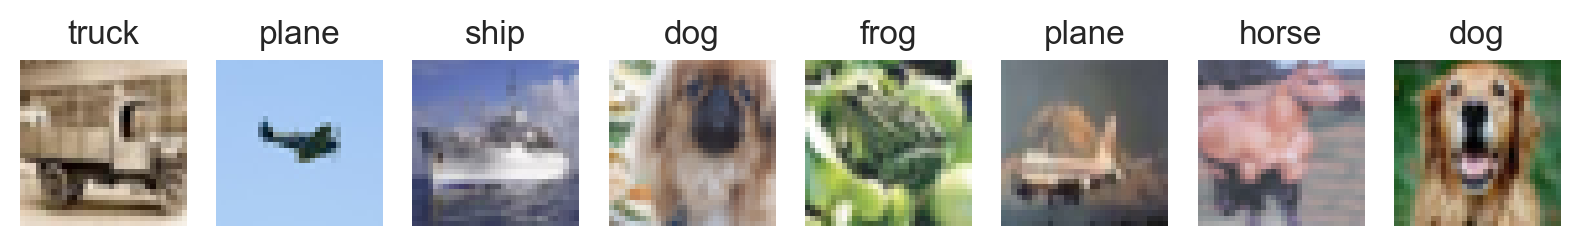

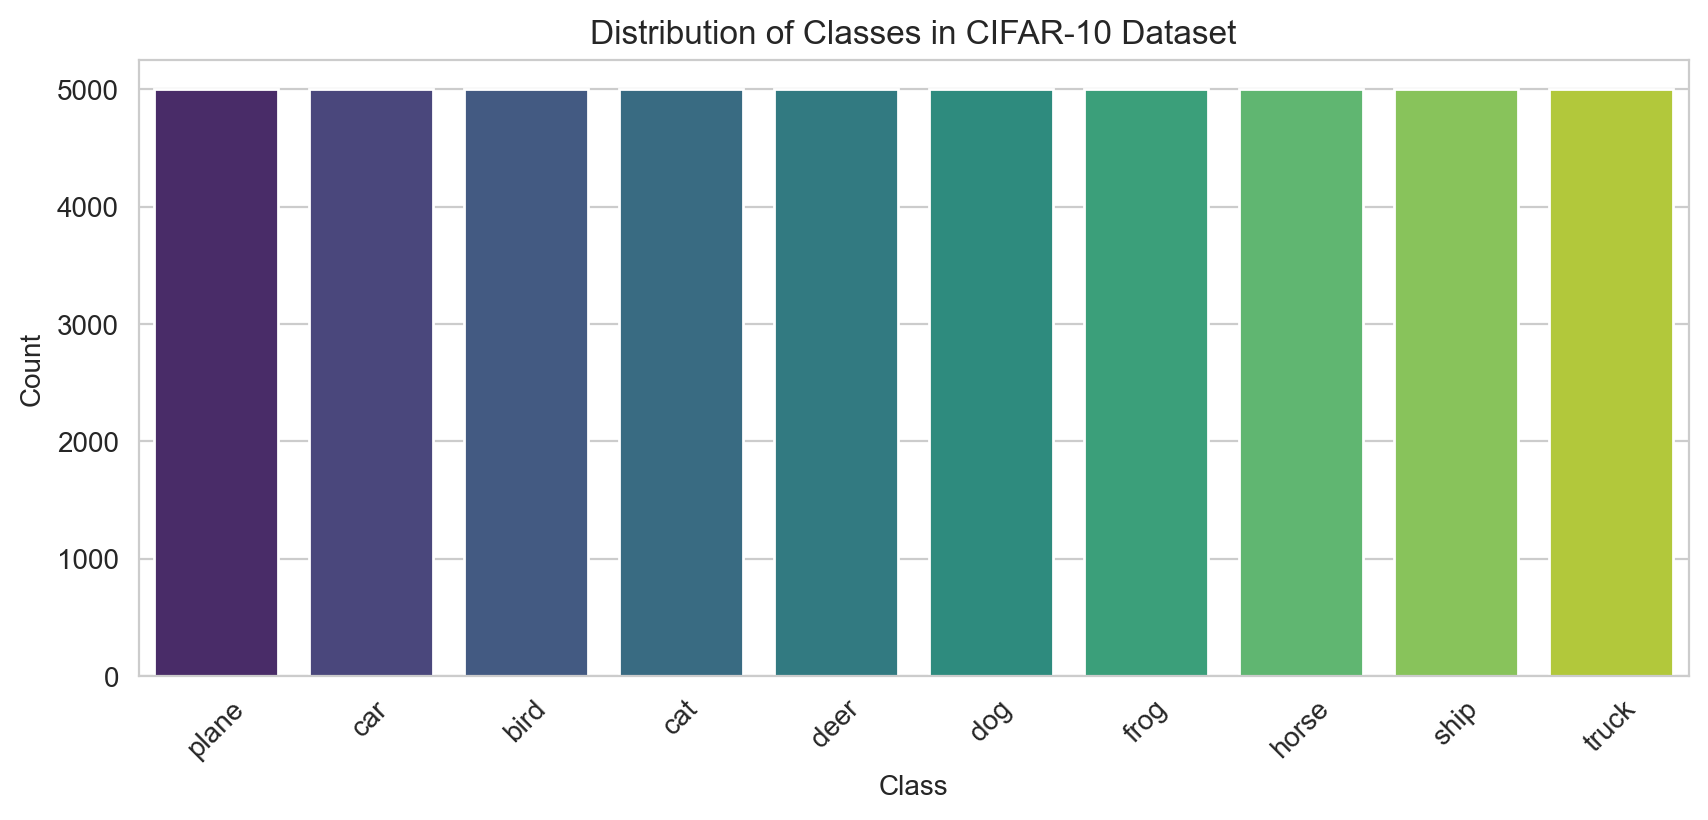

In [10]:
# Cell 3: Exploratory Data Analysis
# Visualize sample images from dataset
def show_real_images(dataloader, num_images=8):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = (real_batch[0][i] + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(classes[real_batch[1][i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_real_images(train_loader)

# Display class distribution
targets = [train_dataset[i][1] for i in range(len(train_dataset))]
plt.figure(figsize=(10, 4))
sns.countplot(x=targets, palette='viridis')
plt.title('Distribution of Classes in CIFAR-10 Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), classes, rotation=45)
plt.show()

In [11]:
# Cell 4: Define Generator and Discriminator networks
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z (noise) -> (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100  # Size of z latent vector
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

print(f"Generator and Discriminator initialized on {device}")
print(f"Generator parameters: {sum(p.numel() for p in netG.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in netD.parameters())}")

Generator and Discriminator initialized on cuda
Generator parameters: 3448576
Discriminator parameters: 663296


In [13]:
# Cell 5: Train GAN model with adversarial loss
# Loss function and optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed noise for visualization
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training parameters
num_epochs = 10
real_label = 1.
fake_label = 0.

# Lists to keep track of progress
G_losses = []
D_losses = []
img_list = []

print("Starting GAN training...")
for epoch in tqdm(range(num_epochs), desc="Training Progress", ncols=80, colour='green'):
    for i, data in enumerate(train_loader, 0):
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()

        # Train with real data
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # Fake labels are real for generator cost

        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Check how the generator is doing by saving G's output on fixed_noise
    if (epoch % 5 == 0) or (epoch == num_epochs - 1):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

print("Training completed!")

Starting GAN training...


Training Progress:   0%|                                 | 0/10 [00:00<?, ?it/s]

[0/10][0/391] Loss_D: 0.2329 Loss_G: 4.7853 D(x): 0.8872 D(G(z)): 0.0659 / 0.0109
[0/10][100/391] Loss_D: 0.3930 Loss_G: 5.2382 D(x): 0.8351 D(G(z)): 0.1745 / 0.0064
[0/10][200/391] Loss_D: 0.9625 Loss_G: 2.7730 D(x): 0.6797 D(G(z)): 0.3681 / 0.0781
[0/10][300/391] Loss_D: 0.3309 Loss_G: 3.4422 D(x): 0.8724 D(G(z)): 0.1639 / 0.0404


Training Progress:  10%|██▌                      | 1/10 [01:22<12:19, 82.16s/it]

[1/10][0/391] Loss_D: 0.6491 Loss_G: 2.5238 D(x): 0.7099 D(G(z)): 0.2086 / 0.1056
[1/10][100/391] Loss_D: 0.3956 Loss_G: 3.3484 D(x): 0.7997 D(G(z)): 0.1165 / 0.0600
[1/10][200/391] Loss_D: 0.3987 Loss_G: 3.6185 D(x): 0.9101 D(G(z)): 0.2251 / 0.0446
[1/10][300/391] Loss_D: 0.5175 Loss_G: 2.8459 D(x): 0.7529 D(G(z)): 0.1614 / 0.0814


Training Progress:  20%|█████                    | 2/10 [02:43<10:51, 81.39s/it]

[2/10][0/391] Loss_D: 0.6786 Loss_G: 2.6952 D(x): 0.7211 D(G(z)): 0.2288 / 0.0938
[2/10][100/391] Loss_D: 0.6448 Loss_G: 2.7279 D(x): 0.7771 D(G(z)): 0.2835 / 0.0858
[2/10][200/391] Loss_D: 0.8131 Loss_G: 4.0521 D(x): 0.9203 D(G(z)): 0.4606 / 0.0294
[2/10][300/391] Loss_D: 0.4865 Loss_G: 2.9694 D(x): 0.8503 D(G(z)): 0.2281 / 0.0713


Training Progress:  30%|███████▌                 | 3/10 [04:03<09:27, 81.11s/it]

[3/10][0/391] Loss_D: 0.3001 Loss_G: 3.0728 D(x): 0.8820 D(G(z)): 0.1440 / 0.0640
[3/10][100/391] Loss_D: 0.9011 Loss_G: 3.6862 D(x): 0.8596 D(G(z)): 0.4703 / 0.0385
[3/10][200/391] Loss_D: 0.3032 Loss_G: 3.1937 D(x): 0.8897 D(G(z)): 0.1471 / 0.0592
[3/10][300/391] Loss_D: 0.5503 Loss_G: 2.5546 D(x): 0.6664 D(G(z)): 0.0812 / 0.1060


Training Progress:  40%|██████████               | 4/10 [05:25<08:07, 81.32s/it]

[4/10][0/391] Loss_D: 0.4604 Loss_G: 4.0867 D(x): 0.8498 D(G(z)): 0.2163 / 0.0277
[4/10][100/391] Loss_D: 0.4863 Loss_G: 2.1803 D(x): 0.7476 D(G(z)): 0.1330 / 0.1426
[4/10][200/391] Loss_D: 0.6374 Loss_G: 2.4622 D(x): 0.7868 D(G(z)): 0.2920 / 0.1090
[4/10][300/391] Loss_D: 0.8880 Loss_G: 3.0180 D(x): 0.8892 D(G(z)): 0.4793 / 0.0656


Training Progress:  50%|████████████▌            | 5/10 [07:10<07:28, 89.73s/it]

[5/10][0/391] Loss_D: 0.6741 Loss_G: 1.5760 D(x): 0.6878 D(G(z)): 0.1988 / 0.2592
[5/10][100/391] Loss_D: 0.8651 Loss_G: 1.3386 D(x): 0.5403 D(G(z)): 0.0985 / 0.3181
[5/10][200/391] Loss_D: 0.6253 Loss_G: 2.1349 D(x): 0.7768 D(G(z)): 0.2731 / 0.1468
[5/10][300/391] Loss_D: 0.7178 Loss_G: 1.6743 D(x): 0.6041 D(G(z)): 0.1326 / 0.2267


Training Progress:  60%|███████████████          | 6/10 [09:01<06:28, 97.01s/it]

[6/10][0/391] Loss_D: 0.8769 Loss_G: 1.5129 D(x): 0.5405 D(G(z)): 0.1261 / 0.2725
[6/10][100/391] Loss_D: 0.7493 Loss_G: 3.0013 D(x): 0.8167 D(G(z)): 0.3817 / 0.0675
[6/10][200/391] Loss_D: 0.8396 Loss_G: 1.5774 D(x): 0.5459 D(G(z)): 0.0988 / 0.2463
[6/10][300/391] Loss_D: 0.8361 Loss_G: 1.8892 D(x): 0.6392 D(G(z)): 0.2615 / 0.1820


Training Progress:  70%|████████████████▊       | 7/10 [10:52<05:05, 101.68s/it]

[7/10][0/391] Loss_D: 0.7196 Loss_G: 2.0913 D(x): 0.7248 D(G(z)): 0.2903 / 0.1554
[7/10][100/391] Loss_D: 0.7089 Loss_G: 1.7453 D(x): 0.6717 D(G(z)): 0.2238 / 0.2124
[7/10][200/391] Loss_D: 0.8340 Loss_G: 2.1604 D(x): 0.7706 D(G(z)): 0.3923 / 0.1434
[7/10][300/391] Loss_D: 1.2436 Loss_G: 3.5573 D(x): 0.8225 D(G(z)): 0.5924 / 0.0390


Training Progress:  80%|███████████████████▏    | 8/10 [12:30<03:20, 100.39s/it]

[8/10][0/391] Loss_D: 0.8463 Loss_G: 2.1499 D(x): 0.7203 D(G(z)): 0.3579 / 0.1416
[8/10][100/391] Loss_D: 0.7674 Loss_G: 1.8500 D(x): 0.6720 D(G(z)): 0.2674 / 0.1841
[8/10][200/391] Loss_D: 1.8122 Loss_G: 4.8553 D(x): 0.9374 D(G(z)): 0.7763 / 0.0116
[8/10][300/391] Loss_D: 0.6734 Loss_G: 1.6926 D(x): 0.6791 D(G(z)): 0.2156 / 0.2210


Training Progress:  90%|█████████████████████▌  | 9/10 [14:12<01:40, 101.00s/it]

[9/10][0/391] Loss_D: 1.4184 Loss_G: 2.4749 D(x): 0.8634 D(G(z)): 0.6530 / 0.1166
[9/10][100/391] Loss_D: 0.7826 Loss_G: 2.0221 D(x): 0.7064 D(G(z)): 0.3133 / 0.1590
[9/10][200/391] Loss_D: 0.7764 Loss_G: 1.7088 D(x): 0.6357 D(G(z)): 0.2259 / 0.2123
[9/10][300/391] Loss_D: 0.7260 Loss_G: 1.7222 D(x): 0.6514 D(G(z)): 0.2157 / 0.2090


Training Progress: 100%|████████████████████████| 10/10 [16:19<00:00, 97.98s/it]

Training completed!


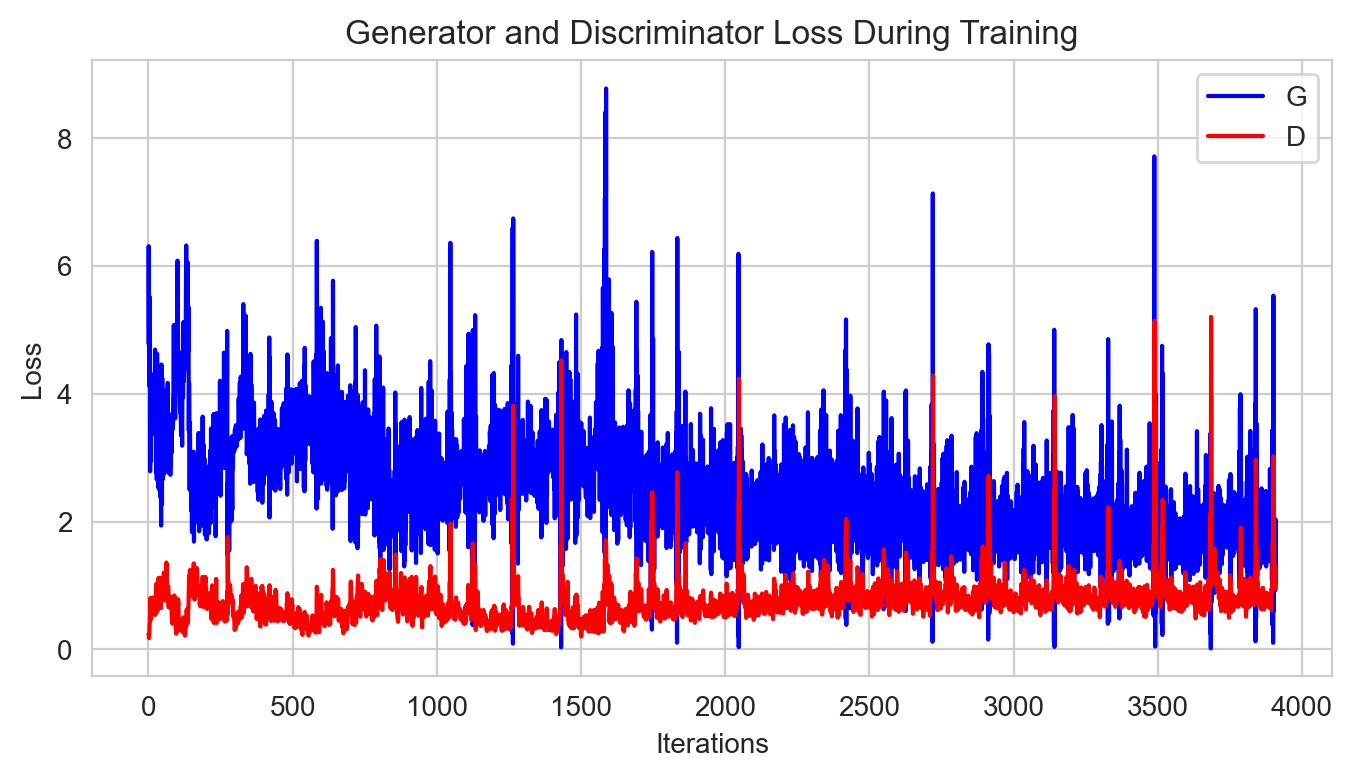

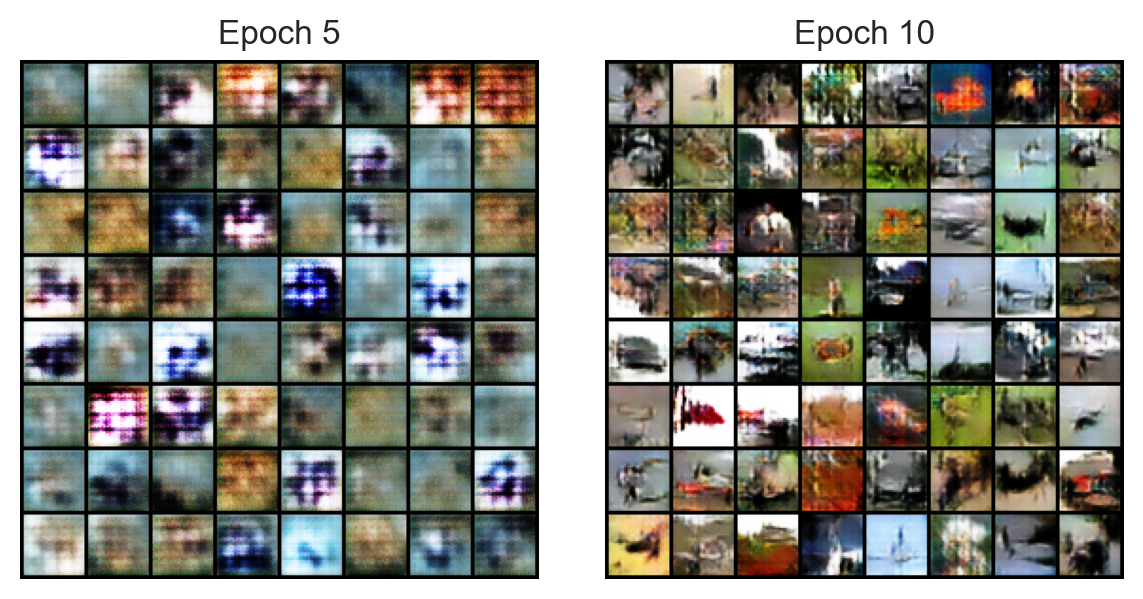

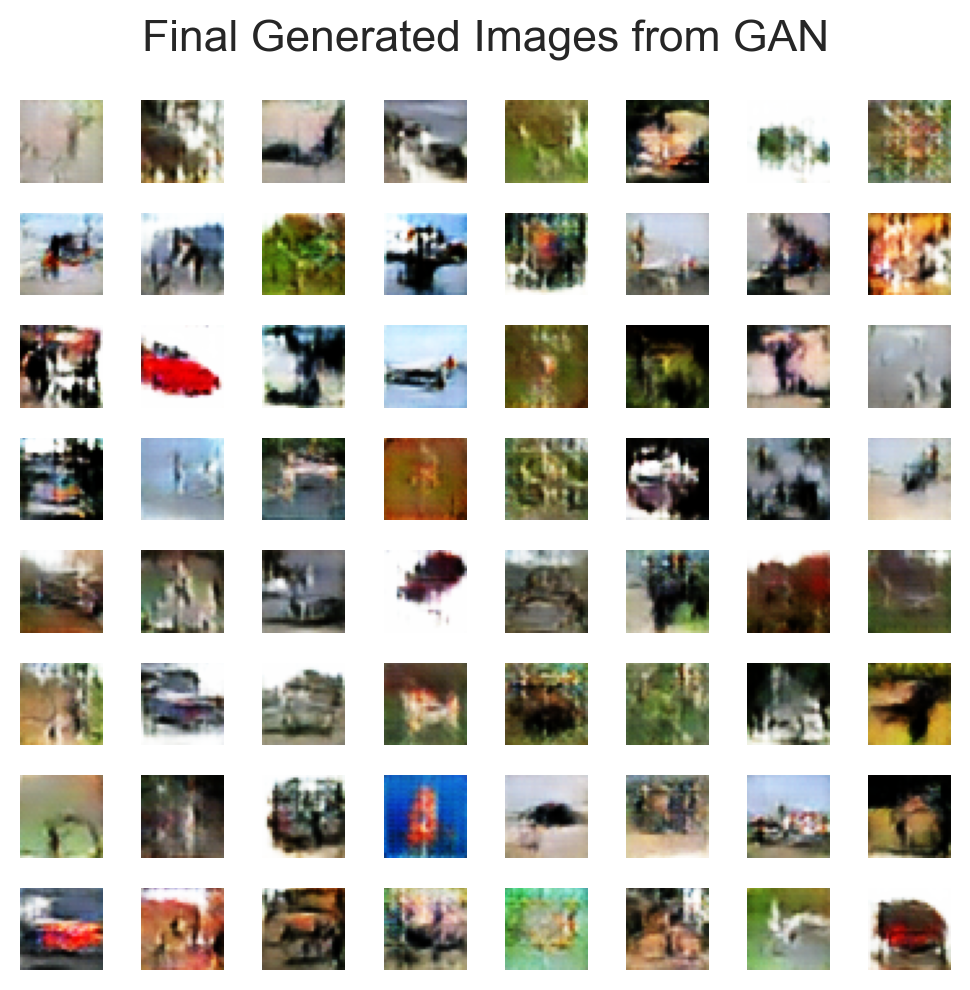

In [20]:
# Cell 6: Visualize training progress and generated images
# Plot GAN losses
plt.figure(figsize=(8, 4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Visualize generated images at different epochs
def show_generated_images(img_list, num_epochs_display=5):
    # Calculate which epochs to display
    total_epochs = num_epochs
    display_interval = max(1, total_epochs // num_epochs_display)
    display_epochs = [i * display_interval for i in range(num_epochs_display) if i * display_interval < len(img_list)]

    if len(display_epochs) == 0 and len(img_list) > 0:
        display_epochs = [len(img_list) - 1]  # Show the last epoch if no other epochs were selected

    fig, axes = plt.subplots(1, len(display_epochs), figsize=(3*len(display_epochs), 3))

    if len(display_epochs) == 1:
        axes = [axes]  # Make sure axes is iterable

    for i, epoch_idx in enumerate(display_epochs):
        img_tensor = img_list[epoch_idx]
        img = np.transpose(img_tensor, (1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(f'Epoch {min((epoch_idx + 1) * 5, total_epochs)}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_generated_images(img_list)

# Generate a final batch of images
with torch.no_grad():
    fake = netG(torch.randn(64, nz, 1, 1, device=device)).detach().cpu()

fig, axes = plt.subplots(8, 8, figsize=(5, 5))
for i in range(64):
    ax = axes[i//8, i%8]
    img = (fake[i] + 1) / 2  # Denormalize
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.axis('off')
plt.suptitle('Final Generated Images from GAN', fontsize=16)
plt.tight_layout()
plt.show()

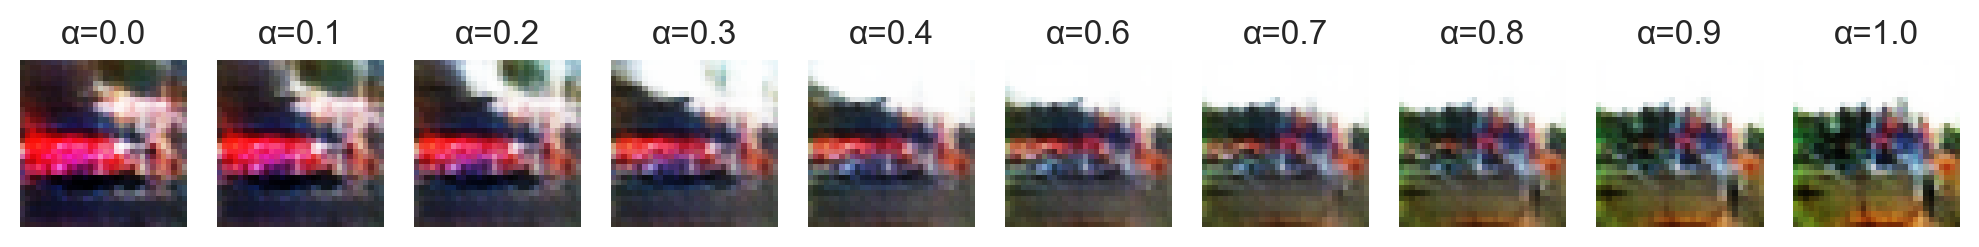

Diversity Score (mean distance between generated samples): 50.4133


In [22]:
# Cell 7: Advanced evaluation and comparison
# Interpolate between two noise vectors to show smooth transitions
def interpolate_noise_vectors():
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.randn(1, nz, 1, 1, device=device)

    # Create intermediate vectors
    alphas = np.linspace(0, 1, 10)
    interpolated_images = []

    for alpha in alphas:
        z_interp = (1 - alpha) * z1 + alpha * z2
        with torch.no_grad():
            fake_img = netG(z_interp).detach().cpu()
        interpolated_images.append(fake_img)

    # Plot interpolation
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    for i, img in enumerate(interpolated_images):
        img = (img[0] + 1) / 2  # Denormalize
        axes[i].imshow(np.transpose(img, (1, 2, 0)))
        axes[i].set_title(f'α={alphas[i]:.1f}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

interpolate_noise_vectors()

# Evaluate mode collapse by calculating diversity metrics
def calculate_diversity_score(num_samples=100):
    netG.eval()
    with torch.no_grad():
        fake_batch = netG(torch.randn(num_samples, nz, 1, 1, device=device))
        # Calculate mean distance between samples as a diversity measure
        fake_flat = fake_batch.view(fake_batch.size(0), -1)
        distances = []
        for i in range(num_samples):
            for j in range(i+1, num_samples):
                dist = torch.norm(fake_flat[i] - fake_flat[j], p=2).item()
                distances.append(dist)
    return np.mean(distances)

diversity_score = calculate_diversity_score()
print(f"Diversity Score (mean distance between generated samples): {diversity_score:.4f}")

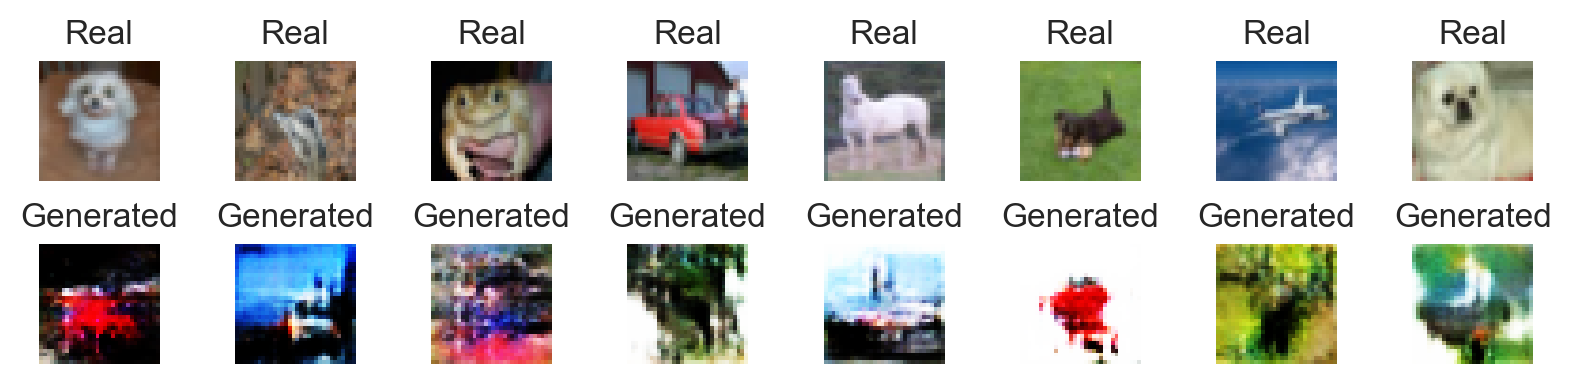


GAN Training Summary:
Total epochs: 10
Final Generator loss: 1.0337
Final Discriminator loss: 0.9437
Total iterations: 3910

Models saved to '../../model/'


In [27]:
# Cell 8: Model analysis and insights
# Generate more samples for qualitative analysis
def generate_and_compare_samples(num_samples=16):
    netG.eval()
    with torch.no_grad():
        fake_samples = netG(torch.randn(num_samples, nz, 1, 1, device=device)).cpu()

    # Get real samples for comparison
    real_samples = next(iter(train_loader))[0][:num_samples]

    # Plot real vs generated
    fig, axes = plt.subplots(2, 8, figsize=(8, 2))

    # Real samples
    for i in range(8):
        img = (real_samples[i] + 1) / 2  # Denormalize
        axes[0, i].imshow(np.transpose(img, (1, 2, 0)))
        axes[0, i].set_title('Real')
        axes[0, i].axis('off')

    # Fake samples
    for i in range(8):
        img = (fake_samples[i] + 1) / 2  # Denormalize
        axes[1, i].imshow(np.transpose(img, (1, 2, 0)))
        axes[1, i].set_title('Generated')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

generate_and_compare_samples()

print(f"\nGAN Training Summary:")
print(f"Total epochs: {num_epochs}")
print(f"Final Generator loss: {G_losses[-1]:.4f}")
print(f"Final Discriminator loss: {D_losses[-1]:.4f}")
print(f"Total iterations: {len(G_losses)}")

# Save models
torch.save(netG.state_dict(), '../../model/generator.pth')
torch.save(netD.state_dict(), '../../model/discriminator.pth')
print("\nModels saved to '../../model/'")